# Task 2: Create a Predictive Algorithm

In your second task, you were expected to create model that classifies your labels that done in the first task.
Create a model by using Python or R. You are free to choose your algorithm and libraries / packages to use.

Finally, tune your hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from utils.aux_functions import univariate_analysis, agg_assign

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [2]:
# read data
df = pd.read_csv('./data/Courier_data.csv')

In [3]:
df.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,lifetime_2,lifetime_1_a,lifetime_1_b,lifetime_1_c,lifetime_1_d,flag
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,...,0.8158,43.384804,1,19,33.0,0,1,0,0,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,...,0.8919,35.078042,3,11,33.0,0,1,0,0,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,...,0.9302,31.455285,1,10,33.0,0,1,0,0,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,...,0.7879,34.252991,1,30,33.0,0,1,0,0,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,...,0.8889,46.478114,1,4,35.0,1,0,0,0,0


In [4]:
df.shape

(3025, 25)

---

## Data Exploration

<h3 class="text-muted">Understanding the flag</h3>
> Our `flag` identifies couriers that did not work in weeks 9 to 11. Therefore, based on weekly observations, we are trying to __predict which couriers did not work in those 9 to 11 last weeks__.

The distribution of flags is relatively balanced (even though there are not so many observations)

In [5]:
pd.DataFrame(
    { 
        'Count': df.groupby('flag')['flag'].count(),
        'Percentage': df.groupby(('flag')).size() / len(df), 
    }
)

,Count,Percentage
flag,,
0,1969,0.650909
1,1056,0.349091


<h3 class="text-muted">Feature importance</h3>

Here we will focus our efforts on identifying good predictors.

<h6 class="text-muted">Correlation matrix</h6>

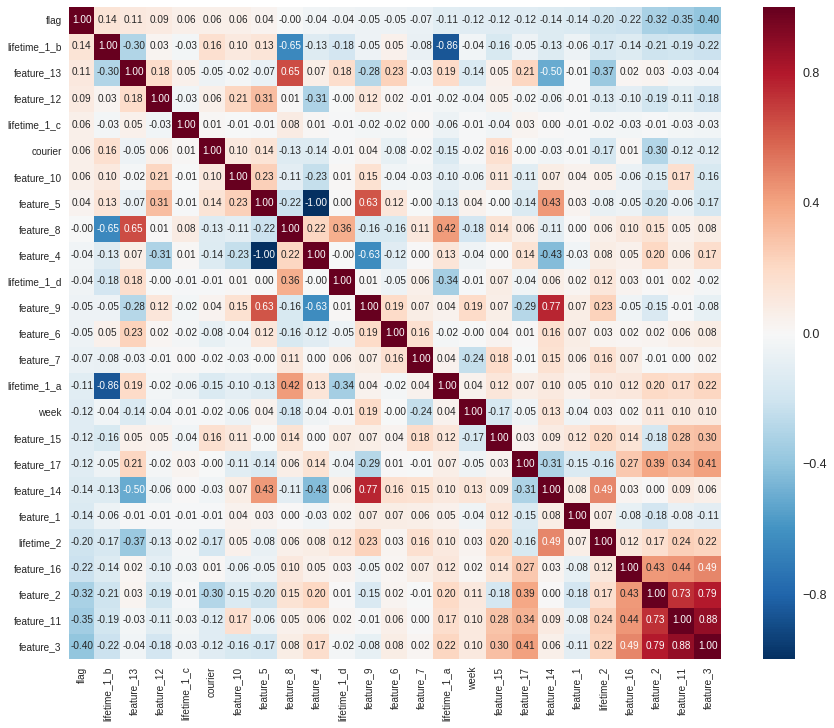

In [6]:
# flag correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
k = 25 #number of variables for heatmap
cols = corrmat.nlargest(k, 'flag')['flag'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h6 class="text-muted">Random Forest (feature importance)</h6>

In [40]:
features = df.columns[
        (~df.columns.str.contains('flag')) &
        (~df.columns.str.contains('courier'))
        ].values

In [41]:
from sklearn.ensemble import RandomForestClassifier

X = df[features].values
y = df['flag'].values

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

df_importances = pd.concat([
    pd.Series(features, name='feature'), 
    pd.Series(rnd_clf.feature_importances_, name='importance')]
    , axis=1)

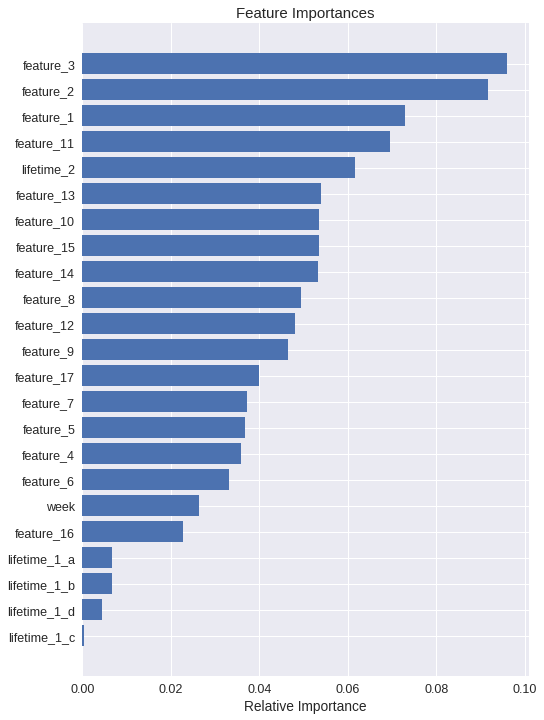

In [42]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(figsize=(8, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

<h6 class="text-muted">Univariate analysis</h6>

Let's now focus on performing an individual analysis for each of the most important features and evaluate how it works with our `flag`. To perform a univariate analysis, we will proceed to bin each feature and compare its distribution with the amount of flagged observations.

In small datasets it is good practice to bin continuous features to avoid overfitting. Therefore, the following univariate analysis is greatly useful at considering the binning technique for modelling later on.

In [43]:
df_importance = pd.DataFrame([features[indices], importances[indices]]).transpose().rename(columns={0:'feature', 1:'importance'}).sort_values('importance', ascending=False)
df_importance.head(10)

,feature,importance
22,feature_3,0.0960483
21,feature_2,0.0916766
20,feature_1,0.072867
19,feature_11,0.0695556
18,lifetime_2,0.0615485
17,feature_13,0.0539035
16,feature_10,0.0535609
15,feature_15,0.0534575
14,feature_14,0.0531867
13,feature_8,0.049499


In [11]:
cols = np.append(features[indices][-8:], ['flag'])

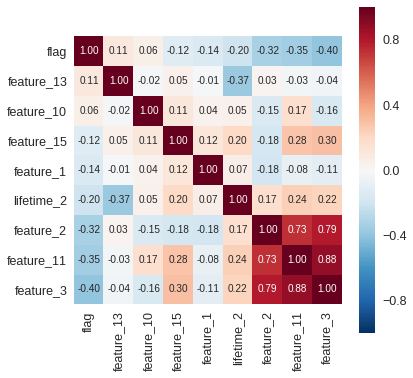

In [12]:
# flag correlation matrix
corrmat = df[cols].corr()
f, ax = plt.subplots(figsize=(6, 6))
k = len(cols) #number of variables for heatmap
cols = corrmat.nlargest(k, 'flag')['flag'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h5 class="text-muted">feature_3</h5>

                  % flag   n1    n
feature_3                         
(1.0, 24.0]     0.665354  338  508
(24.0, 47.0]    0.451306  380  842
(47.0, 70.0]    0.274684  217  790
(70.0, 92.0]    0.188100   98  521
(92.0, 115.0]   0.077220   20  259
(115.0, 138.0]  0.038961    3   77
(138.0, 161.0]  0.000000    0   19
(161.0, 184.0]  0.000000    0    9


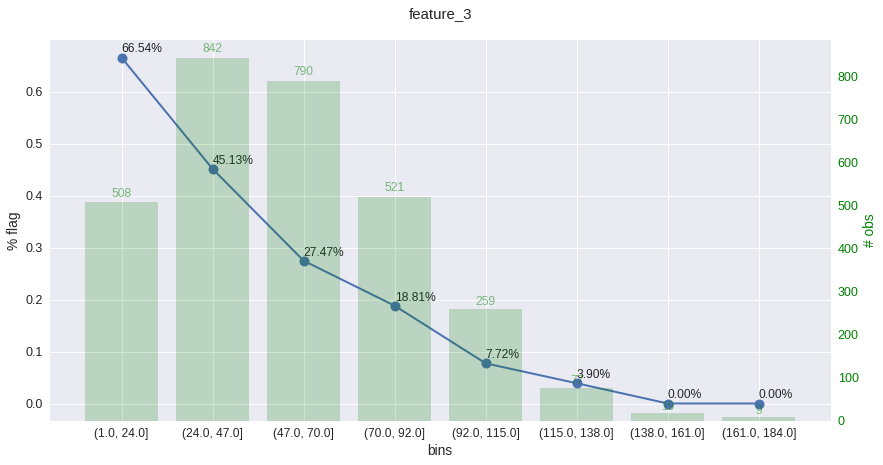

In [13]:
univariate_analysis(df, 'feature_3', 'flag', bins=8, precision=0)

The tip provided "*distribution of feature_3 is a hint how the data is generated*" specially makes sense here when comparing this feature with the `flag` for each bin. We can clearly see that the first bucket (<=24) has the largest amount of `flag`. This means that these courier-week combinations correspond to couriers that did not work after the 9th week (`flag` = 1). Therefore, the larger the `feature_3`, the larger the chances those couriers worked in weeks 9 to 11. Conversely, the lower the `feature_3`, the lower the chances those couriers worked in last weeks of the time window.

Now let's examine why there is so much correlation between `feature_3` and `feature_11` and `feature_2`.

<h5 class="text-muted">feature_11</h5>

                   % flag   n1    n
feature_11                         
(-0.082, 10.25]  0.611797  446  729
(10.25, 20.5]    0.366492  350  955
(20.5, 30.75]    0.247368  188  760
(30.75, 41.0]    0.124682   49  393
(41.0, 51.25]    0.120567   17  141
(51.25, 61.5]    0.171429    6   35
(61.5, 71.75]    0.000000    0    9
(71.75, 82.0]    0.000000    0    3


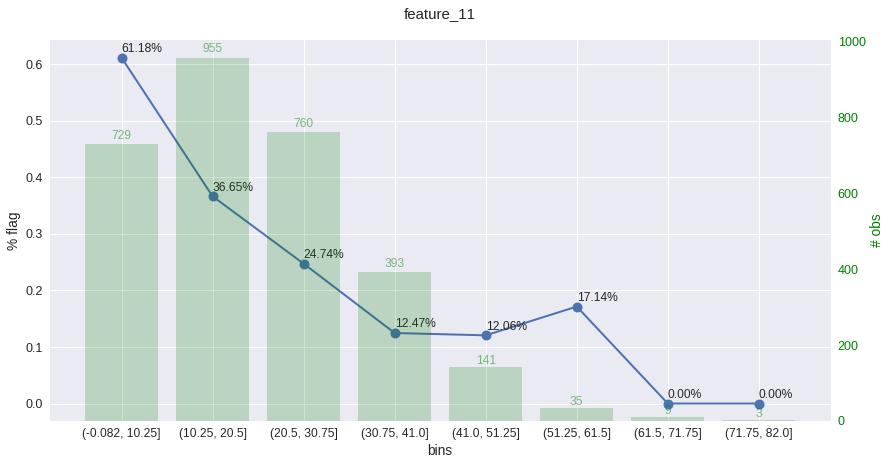

In [14]:
univariate_analysis(df, 'feature_11', 'flag', bins=8)

<h5 class="text-muted">feature_2</h5>

                  % flag   n1     n
feature_2                          
(1.0, 29.0]     0.583772  554   949
(29.0, 57.0]    0.280543  372  1326
(57.0, 85.0]    0.174497  104   596
(85.0, 113.0]   0.128205   15   117
(113.0, 141.0]  0.250000    8    32
(141.0, 169.0]  0.600000    3     5


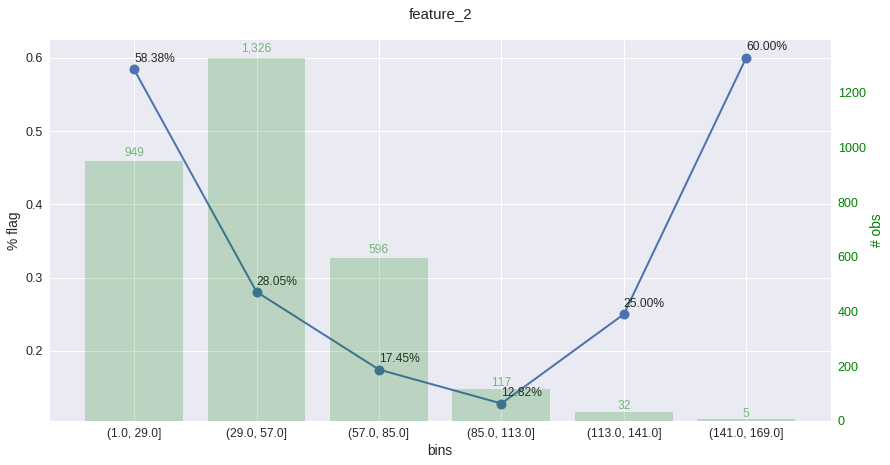

In [15]:
univariate_analysis(df, 'feature_2','flag', bins=6, precision=0)

It can be clearly seen that correlations among these three features come from:

* The distribution of each feature follows the same pattern (__the majority of the population is concentrated in the first bins, usually with larger amount of flagged observations__).

<h5 class="text-muted">lifetime_2</h5>

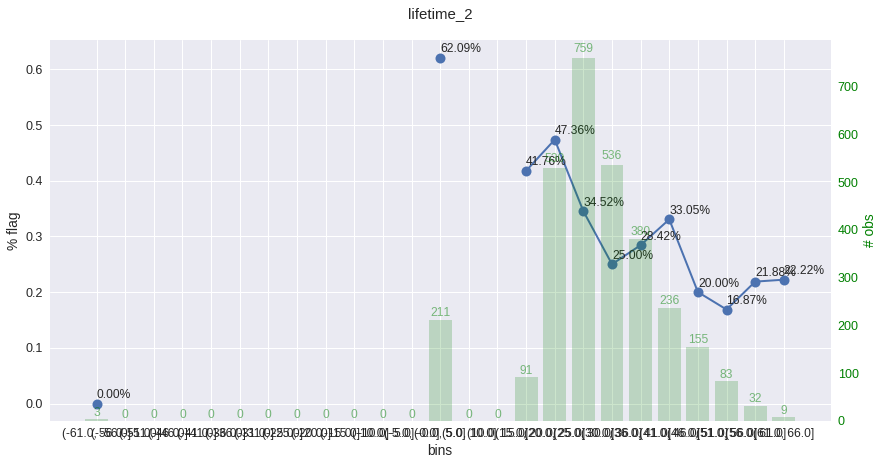

In [18]:
univariate_analysis(df, 'lifetime_2', 'flag', bins=25, precision=0, detail=False)

There is high correlation between `feature_3`, `feature_11` and `feature_2`. It is interesting that `lifetime_2` is not correlated with these 3 features and has a relatively high importance with the `flag`. A more suitable binning is shown below.

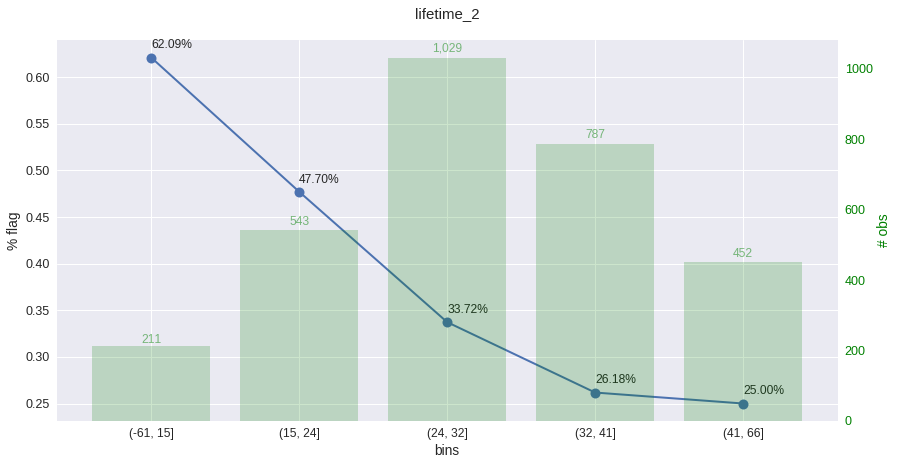

In [24]:
univariate_analysis(df, 'lifetime_2', 'flag', bins=[-61, 15, 24, 32, 41, 66], precision=0, detail=False)

<h5 class="text-muted">feature_10</h5>

                % flag   n1     n
feature_10                       
(3.0, 4.0]    0.750000    3     4
(4.0, 6.0]    0.827586   24    29
(6.0, 7.0]    0.530435   61   115
(7.0, 9.0]    0.311644  182   584
(9.0, 10.0]   0.286517  306  1068
(10.0, 12.0]  0.346447  273   788
(12.0, 13.0]  0.414141  123   297
(13.0, 15.0]  0.526882   49    93
(15.0, 16.0]  0.709677   22    31
(16.0, 18.0]  0.750000    6     8
(18.0, 19.0]  1.000000    5     5
(19.0, 21.0]  0.666667    2     3


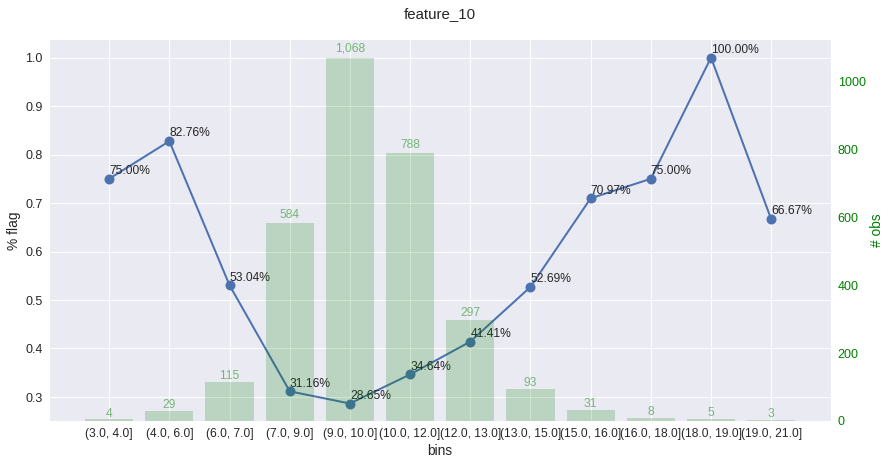

In [33]:
univariate_analysis(df, 'feature_10', 'flag', bins=12, precision=0)

---

## Preprocessing

<h6 class="text-muted">Standardization</h6>

Necessary since there are features with completely different scales.

In [48]:
predictors = df_importances.sort_values('importance', ascending=False)['feature'].head(15).values

In [51]:
from sklearn.preprocessing import StandardScaler

all_predictors = [x for x in df.columns if x not in ['flag', 'courier', 'week']]

scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df[all_predictors]), columns=all_predictors)
df2['flag'] = df['flag']
df2['courier'] = df['courier']

<h6 class="text-muted">PCA to extract new features</h6>

Following the hint provided, new features (2) will be extracted from `feature_3` in combination with other ones. We will use PCA in an iterative way until we find the right combination of features such that the principal components have a large predictive power.

In [71]:
features = df2.columns[df2.columns.str.contains('lifetime_1')].values

# Separating out the features
X = df2.loc[:, features].values

# Separating out the target
y = df2[['flag']]

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [73]:
finalDf = pd.concat([principalDf, y], axis = 1)

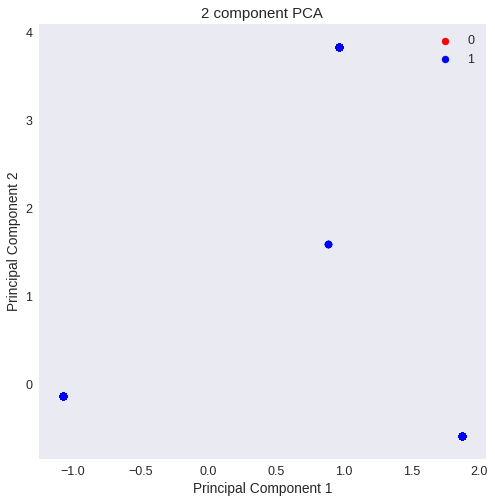

In [74]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
flags = [0,1]
colors = ['r','b']
for flag, color in zip(flags,colors):
    indicesToKeep = finalDf['flag'] == flag
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(flags)
ax.grid()

In [75]:
df3 = pd.concat([df2, finalDf[['PC1', 'PC2']]], axis=1)

In [ ]:
predictors = [x for x in df3.columns if x not in ['flag', 'courier']]

In [76]:
# Choose all features except flag
features = [x for x in df3.columns if x not in ['flag']]
target = 'flag'

X = df3[features].values
y = df3[target].values

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [78]:
train = pd.DataFrame(X_train, columns=[features])
train[target] = list(y_train)

test = pd.DataFrame(X_test, columns=[features])
test[target] = y_test

In [80]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

('X_train:', (2722, 25))
('X_test:', (303, 25))
('y_train:', (2722,))
('y_test:', (303,))


In [ ]:
univariate_analysis(df3, 'PC1', 'flag', bins=4)

Remove features not necessary for modelling:
* `courier`: not used to model since it is just an id (the model results would be definitely better but would not be realistic for production purposes).
* `feature_5`: we have seen that has complete negative correlation with `feature_4`.
* `lifetime_1`: already included in PCA features.

---
<h2>Model 1 <span class="text-muted">SVM</span></h2>

In [81]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0)
clf.fit(train[predictors].values, train['flag'].values.flatten())

#print(clf.coef_)
#print(clf.intercept_)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % metrics.roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % metrics.roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.691025

Model Report (Test)
AUC Score: 0.689636


---
<h2>Model 2 <span class="text-muted">Lasso</span></h2>

In [83]:
from sklearn.linear_model import Lasso

clf = Lasso(alpha=0.001, random_state=0)
clf.fit(train[predictors].values, train['flag'].values)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % metrics.roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % metrics.roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.784915

Model Report (Test)
AUC Score: 0.785825


---
<h2>Model 3 <span class="text-muted">XGBoost</span></h2>

In [84]:
import xgboost as xgb
from xgboost import XGBClassifier

def modelfit(alg, 
             dtrain, 
             dtest, 
             predictors, 
             verbose=0, 
             useTrainCV=True, 
             cv_folds=5, 
             early_stopping_rounds=50, 
             target='flag'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values.flatten())
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds, 
            verbose_eval=verbose)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_params())
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target].values.flatten(),eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print( "\nModel Report (Train)")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print( "AUC Score: %f" % metrics.roc_auc_score(dtrain[target].values, dtrain_predprob))
    
    # Predict validation set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    # Print model report:
    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(dtest[target].values, dtest_predprob))
    
    features_df = pd.DataFrame({'feature': pd.Series(predictors), 'importance': alg.feature_importances_})
    features_df = features_df.sort_values('importance', ascending=False)
    ind = np.arange(len(features_df['feature'].values))    # the x locations for the groups
    
    pyplot.figure(num=None, figsize=[12,4])
    pyplot.bar(range(len(features_df)), features_df['importance'].values)
    pyplot.xticks(ind, features_df['feature'].values, rotation='vertical')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* __max_depth = 5:__ This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* __min_child_weight = 1:__ A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* __gamma = 0:__ A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* __subsample, colsample_bytree = 0.8:__ This is a commonly used used start value. Typical values range between 0.5-0.9.
* __scale_pos_weight = 1:__ Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take a low __learning rate of 0.1__ here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

{'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 65, 'subsample': 0.8, 'reg_lambda': 1, 'random_state': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 27, 'max_depth': 5, 'gamma': 0, 'booster': 'gbtree'}

Model Report (Train)
Accuracy : 0.8902
AUC Score: 0.959831

Model Report (Test)
AUC Score: 0.804757


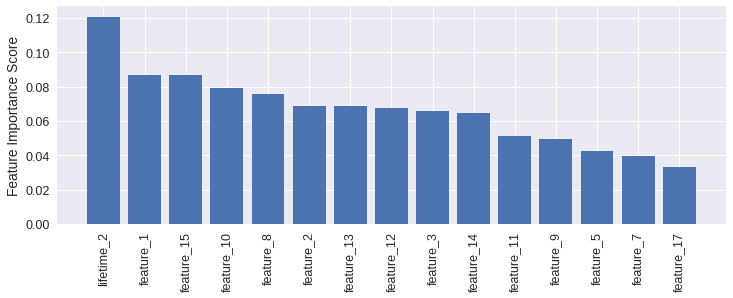

In [85]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, test, predictors)

## GridSearch

We use GridSearch to find the optimal combination of hyperparameters. A search consists of:
* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

<h6 class="text-muted">Step 1: Tune max_depth and min_child_weight</h6>

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [ ]:
from sklearn.model_selection import GridSearchCV #Perforing grid search

param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=False)

gsearch1.fit(train[predictors].values, train[target].values.flatten())

#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

There is high risk of overfitting for such large value for `max_depth`. Therefore, we are going to explore a narrower parameter space which should yield better results when generalising to test dataset.

In [ ]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)

gsearch2.fit(train[predictors].values,train[target].values.flatten())

#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

In [ ]:
modelfit(gsearch2.best_estimator_, train, test, predictors)
gsearch2.best_params_, gsearch2.best_score_

The optimal values are `max_depth` = 5 and `min_child_weight` = 2, for now.

<h6 class="text-muted">Step 2: Tune gamma</h6>

Now let's tune gamma value using the parameters already tuned above. 

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch3.fit(train[predictors].values, train[target].values.flatten())

gsearch3.best_params_, gsearch3.best_score_

This shows that our original value of `gamma` = 0 was optimal. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train, test, predictors)

Here, we can see the improvement in score. So the final parameters are:

* `max_depth`: 5
* `min_child_weight`: 2
* `gamma`: 0

Nonetheless, if we manually raise the value of `gamma` to 0.1 the results improve both in the train and test set.

In [ ]:
xgb2b = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2b, train, test, predictors)

<h6 class="text-muted">Step 3: Tune subsample and colsample_bytree</h6>

The next step would be try different `subsample` and `colsample_bytree` values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with. 

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch4.fit(train[predictors].values, train[target].values.flatten())

gsearch4.best_params_, gsearch4.best_score_

Here, we found 0.8 as the optimum value for `colsample_bytree` and 0.9 for `subsample`. Now we should try values in 0.05 interval around these.

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,95,5)],
 'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch5.fit(train[predictors].values, train[target].values.flatten())

gsearch5.best_params_, gsearch5.best_score_

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, test, predictors)

The optimum values are:

* `subsample`: 0.90
* `colsample_bytree`: 0.85

However, 0.80 for both values works better.

<h6 class="text-muted">Step 4: Tuning Regularization Parameters</h6>

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. I’ll tune `reg_alpha` value here and leave it upto you to try different values of `reg_lambda`.

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch6.fit(train[predictors].values, train[target].values.flatten())

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, train, test, predictors)

<h6 class="text-muted">Step 5: Reducing the Learning Rate</h6>

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [ ]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb5, train, test, predictors)

Reducing the `learning_rate` did no work as expected and the score reduced slightly.

<h6 class="text-muted">Saving the Model</h6>

In [ ]:
import pickle

# save model to file
pickle.dump(xgb4, open("xgb.pickle.dat", "wb"))

<h6 class="text-muted">Exporting data</h6>

In [ ]:
train['train'] = 1
test['train'] = 0

df_total = pd.concat([train, test]).reset_index().drop('index', axis=1)

In [ ]:
df_total.to_csv('./data/Courier_data_model.csv', sep=',', index=False)